In [1]:
from birdcall.data import *

import pandas as pd
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from torch.utils.data import Dataset
import numpy as np

In [2]:
recs = pd.read_pickle('data/recs.pkl')

## Going from audio to mel spectrogram

The below adapts [code](https://github.com/f0k/birdclef2018/blob/master/experiments/audio.py) by Jan Schlüter accompanying this very informative [paper](http://ceur-ws.org/Vol-2125/paper_181.pdf).

In [3]:
audio, _ = sf.read('data/train_resampled/norpar/XC173778.wav')

In [4]:
audio.shape[0] / SAMPLE_RATE

57.456

In [5]:
audio = audio[:5*SAMPLE_RATE] # grabbing only the first five seconds

In [6]:
#export data

from pyfftw.builders import rfft as rfft_builder
from pyfftw import empty_aligned

mel_bands=80
mel_min=27.5
mel_max=10000

In [7]:
#export data

def spectrogram(samples, sample_rate, frame_len, fps, batch=48, dtype=None,
                bins=None, plans=None):
    """
    Computes a magnitude spectrogram for a given vector of samples at a given
    sample rate (in Hz), frame length (in samples) and frame rate (in Hz).
    Allows to transform multiple frames at once for improved performance (with
    a default value of 48, more is not always better). Returns a numpy array.
    Allows to return a limited number of bins only, with improved performance
    over discarding them afterwards. Optionally accepts a set of precomputed
    plans created with spectrogram_plans(), required when multi-threading.
    """
    if dtype is None:
        dtype = samples.dtype
    if bins is None:
        bins = frame_len // 2 + 1
    if len(samples) < frame_len:
        return np.empty((0, bins), dtype=dtype)
    if plans is None:
        plans = spectrogram_plans(frame_len, batch, dtype)
    rfft1, rfft, win = plans
    hopsize = int(sample_rate // fps)
    num_frames = (len(samples) - frame_len) // hopsize + 1
    nabs = np.abs
    naa = np.asanyarray
    if batch > 1 and num_frames >= batch and samples.flags.c_contiguous:
        frames = np.lib.stride_tricks.as_strided(
                samples, shape=(num_frames, frame_len),
                strides=(samples.strides[0] * hopsize, samples.strides[0]))
        spect = [nabs(rfft(naa(frames[pos:pos + batch:], dtype) * win)[:, :bins])
                 for pos in range(0, num_frames - batch + 1, batch)]
        samples = samples[(num_frames // batch * batch) * hopsize::]
        num_frames = num_frames % batch
    else:
        spect = []
    if num_frames:
        spect.append(np.vstack(
                [nabs(rfft1(naa(samples[pos:pos + frame_len:],
                                dtype) * win)[:bins:])
                 for pos in range(0, len(samples) - frame_len + 1, hopsize)]))
    return np.vstack(spect) if len(spect) > 1 else spect[0]


def create_mel_filterbank(sample_rate, frame_len, num_bands, min_freq,
                          max_freq):
    """
    Creates a mel filterbank of `num_bands` triangular filters, with the first
    filter starting at `min_freq` and the last one stopping at `max_freq`.
    Returns the filterbank as a matrix suitable for a dot product against
    magnitude spectra created from samples at a sample rate of `sample_rate`
    with a window length of `frame_len` samples.
    """
    # prepare output matrix
    input_bins = (frame_len // 2) + 1
    filterbank = np.zeros((input_bins, num_bands))

    # mel-spaced peak frequencies
    min_mel = 1127 * np.log1p(min_freq / 700.0)
    max_mel = 1127 * np.log1p(max_freq / 700.0)
    spacing = (max_mel - min_mel) / (num_bands + 1)
    peaks_mel = min_mel + np.arange(num_bands + 2) * spacing
    peaks_hz = 700 * (np.exp(peaks_mel / 1127) - 1)
    fft_freqs = np.linspace(0, sample_rate / 2., input_bins)
    peaks_bin = np.searchsorted(fft_freqs, peaks_hz)

    # fill output matrix with triangular filters
    for b, filt in enumerate(filterbank.T):
        # The triangle starts at the previous filter's peak (peaks_freq[b]),
        # has its maximum at peaks_freq[b+1] and ends at peaks_freq[b+2].
        left_hz, top_hz, right_hz = peaks_hz[b:b + 3]  # b, b+1, b+2
        left_bin, top_bin, right_bin = peaks_bin[b:b + 3]
        # Create triangular filter compatible to yaafe
        filt[left_bin:top_bin] = ((fft_freqs[left_bin:top_bin] - left_hz) /
                                  (top_bin - left_bin))
        filt[top_bin:right_bin] = ((right_hz - fft_freqs[top_bin:right_bin]) /
                                   (right_bin - top_bin))
        filt[left_bin:right_bin] /= filt[left_bin:right_bin].sum()

    return filterbank

def spectrogram_plans(frame_len, batch=48, dtype=np.float32):
    """
    Precompute plans for spectrogram(), for a given frame length, batch size
    and dtype. Returns two plans (single spectrum and batch), and a window.
    """
    input_array = empty_aligned((batch, frame_len), dtype=dtype)
    win = np.hanning(frame_len).astype(dtype)
    return (rfft_builder(input_array[0]), rfft_builder(input_array), win)

In [8]:
spec = spectrogram(audio, SAMPLE_RATE, 256, 128)

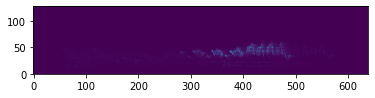

In [9]:
plt.imshow(spec.T, origin='lower')

In [10]:
filterbank = create_mel_filterbank(SAMPLE_RATE, 256, mel_bands, mel_min, mel_max)

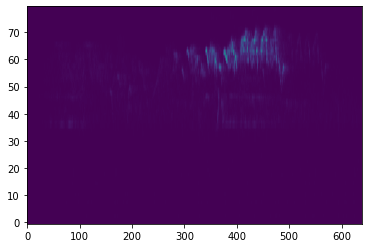

In [11]:
plt.imshow((spec @ filterbank).T, origin='lower', aspect='auto')

Pulling it all together into a datset

In [12]:
#export data

def audio_to_melspec(audio):
    spec = spectrogram(audio, SAMPLE_RATE, 256, 128)
    filterbank = create_mel_filterbank(SAMPLE_RATE, 256, mel_bands, mel_min, mel_max)
    return (spec @ filterbank).T

In [17]:
#export data

class MelspecPoolDataset(Dataset):
    def __init__(self, recs, classes, len_mult=20, specs_per_example=30, normalize=True):
        self.recs = recs
        self.vocab = classes
        self.specs_per_example = specs_per_example
        self.len_mult = len_mult
        self.do_norm = normalize
        
    def __getitem__(self, idx):
        cls_idx = idx % len(self.vocab)
        recs = self.recs[classes[cls_idx]]
        path, duration = recs[np.random.randint(0, len(recs))]
        example = self.sample_specs(path, duration, self.specs_per_example)
        if self.do_norm: example = self.normalize(example)
        imgs = example.reshape(-1, 3, 80, 212)
        return imgs.astype(np.float32), self.one_hot_encode(cls_idx)
    
    def sample_specs(self, path, duration, count):
        x, _ = sf.read(path)

        if x.shape[0] < 1.66*SAMPLE_RATE:
            x =  np.tile(x, 5) # the shortest rec in the train set is 0.39 sec

        xs = []
        for _ in range(count):
            start_frame = int(np.random.rand() * (x.shape[0] - 1.66 * SAMPLE_RATE))
            xs.append(x[start_frame:start_frame+int(1.66*SAMPLE_RATE)])

        specs = []
        for x in xs:
            specs.append(audio_to_melspec(x))
        return np.stack(specs)
    
    def normalize(self, example):
        return (example - 0.12934518) / 0.5612393
    
    def show(self, idx):
        x = self[idx][0][0]
        return plt.imshow(x.transpose(1,2,0)[:, :, 0])
        
    def one_hot_encode(self, y):
        one_hot = np.zeros((len(self.vocab)))
        one_hot[y] = 1
        return one_hot
    def __len__(self):
        return self.len_mult * len(self.vocab)

In [18]:
classes = pd.read_pickle('data/classes.pkl')
train_ds = MelspecPoolDataset(pd.read_pickle('data/train_set.pkl'), classes)
valid_ds = MelspecPoolDataset(pd.read_pickle('data/val_set.pkl'), classes, len_mult=10)

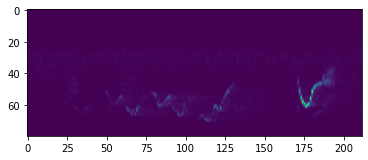

In [27]:
train_ds.show(0)

In [28]:
%%time
x = []
for i in range(264*3):
    x.append(train_ds[i][0])

CPU times: user 15min 22s, sys: 49.4 s, total: 16min 11s
Wall time: 2min 4s


In [271]:
np.stack(x).mean(), np.stack(x).std()

(0.12934518, 0.5612393)